# Project: Predicting autism diagnosis from fMRI data

In [1]:
#ajout de commentaires: test pour gihhub push!!!
#import librairies
import os
import pandas as pd
import nibabel as nib
import nilearn as nl
import seaborn as sns
from nilearn import plotting as nlp
from nilearn import datasets
import matplotlib.pyplot as plt
import numpy as np

import plotly
import plotly.graph_objects as go
import chart_studio
import chart_studio.plotly as py
from chart_studio import tools
from plotly.offline import iplot, init_notebook_mode
import cufflinks
cufflinks.go_offline(connected=True)
init_notebook_mode(connected=True)
from sklearn.model_selection import validation_curve
from sklearn.svm import SVC

# Data exploration with static plotting

In [2]:
data=nl.datasets.fetch_abide_pcp()

/home/anproulx/miniconda3/lib/python3.7/site-packages/numpy/lib/npyio.py:2372: VisibleDeprecationWarning:

Reading unicode strings without specifying the encoding argument is deprecated. Set the encoding, use None for the system default.



In [39]:
data.keys()

#len(data.func_preproc) 

dict_keys(['description', 'phenotypic', 'func_preproc'])

In [3]:
pheno=pd.DataFrame(data.phenotypic)
phen=pheno.drop("Unnamed_0", axis=1)

phen.head()

i  SUB_ID  X  subject  SITE_ID          FILE_ID  DX_GROUP  DSM_IV_TR  \
0  1   50003  2    50003  b'PITT'  b'Pitt_0050003'         1          1   
1  2   50004  3    50004  b'PITT'  b'Pitt_0050004'         1          1   
2  3   50005  4    50005  b'PITT'  b'Pitt_0050005'         1          1   
3  4   50006  5    50006  b'PITT'  b'Pitt_0050006'         1          1   
4  5   50007  6    50007  b'PITT'  b'Pitt_0050007'         1          1   

   AGE_AT_SCAN  SEX  ... qc_notes_rater_1  qc_anat_rater_2  \
0        24.45    1  ...              b''            b'OK'   
1        19.09    1  ...              b''            b'OK'   
2        13.73    2  ...              b''            b'OK'   
3        13.37    1  ...              b''            b'OK'   
4        17.78    1  ...              b''            b'OK'   

   qc_anat_notes_rater_2  qc_func_rater_2          qc_func_notes_rater_2  \
0                    b''            b'OK'                            b''   
1                    b''            b'OK'                            b''   
2                    b''         b'maybe'      b'ic-parietal-cerebellum'   
3                    b''         b'maybe'          b'ic-parietal slight'   
4                    b''         b'maybe'  b'ic-cerebellum_temporal_lob'   

  qc_anat_rater_3 qc_anat_notes_rater_3 qc_func_rater_3  \
0           b'OK'                   b''           b'OK'   
1           b'OK'                   b''           b'OK'   
2           b'OK'                   b''           b'OK'   
3           b'OK'                   b''           b'OK'   
4           b'OK'                   b''           b'OK'   

   qc_func_notes_rater_3  SUB_IN_SMP  
0                    b''           1  
1                    b''           1  
2                    b''           0  
3                    b''           1  
4                    b''           1  

[5 rows x 105 columns]

In [4]:
#replace encoded values with labels

pheno_lab= phen["DX_GROUP"].replace([1 , 2], ["autism", "control"]) #1 is autism, 2 is control
phen["DX_GROUP"]=pheno_lab

pheno_lab= phen["SEX"].replace([1 , 2], ["male", "female"]) #1 is male, 2 is female
phen["SEX"]=pheno_lab

pheno_lab= phen["DSM_IV_TR"].replace([0 , 1 , 2 , 3 , 4 , -9999], ["control", "autism" , "asperger" , "PPD-NOS", "Asperger or PPD-NOS", "NaN"]) #O is control, 1 is autism, 2 is Asperger, 3 is PPD-NOS, 4 is Asperger or PPD-NOS
phen["DSM_IV_TR"]=pheno_lab
pd.set_option('display.max_columns', 500)
phen.head()

i  SUB_ID  X  subject  SITE_ID          FILE_ID DX_GROUP DSM_IV_TR  \
0  1   50003  2    50003  b'PITT'  b'Pitt_0050003'   autism    autism   
1  2   50004  3    50004  b'PITT'  b'Pitt_0050004'   autism    autism   
2  3   50005  4    50005  b'PITT'  b'Pitt_0050005'   autism    autism   
3  4   50006  5    50006  b'PITT'  b'Pitt_0050006'   autism    autism   
4  5   50007  6    50007  b'PITT'  b'Pitt_0050007'   autism    autism   

   AGE_AT_SCAN     SEX HANDEDNESS_CATEGORY  HANDEDNESS_SCORES    FIQ  VIQ  \
0        24.45    male                b'R'                NaN  124.0  128   
1        19.09    male                b'R'                NaN  113.0  108   
2        13.73  female                b'R'                NaN  119.0  117   
3        13.37    male                b'L'                NaN  109.0   99   
4        17.78    male                b'R'                NaN  110.0  106   

   PIQ FIQ_TEST_TYPE VIQ_TEST_TYPE PIQ_TEST_TYPE  ADI_R_SOCIAL_TOTAL_A  \
0  115       b'WASI'       b'WASI'       b'WASI'                    27   
1  117       b'WASI'       b'WASI'       b'WASI'                    19   
2  118       b'WASI'       b'WASI'       b'WASI'                    23   
3  119       b'WASI'       b'WASI'       b'WASI'                    13   
4  112       b'WASI'       b'WASI'       b'WASI'                    21   

   ADI_R_VERBAL_TOTAL_BV  ADI_RRB_TOTAL_C  ADI_R_ONSET_TOTAL_D  \
0                     22                5                    3   
1                     12                5                    3   
2                     19                3                    4   
3                     10                4                    3   
4                     14                9                    1   

   ADI_R_RSRCH_RELIABLE  ADOS_MODULE  ADOS_TOTAL  ADOS_COMM  ADOS_SOCIAL  \
0                     1            4          13          5            8   
1                     1            4          18          6           12   
2                     1            4          12          4            8   
3                     1            4          12          4            8   
4                     1            3          17          5           12   

   ADOS_STEREO_BEHAV  ADOS_RSRCH_RELIABLE  ADOS_GOTHAM_SOCAFFECT  \
0                  1                    1                     -1   
1                  2                    1                     -1   
2                  1                    1                     -1   
3                  4                    1                     -1   
4                  2                    1                     -1   

   ADOS_GOTHAM_RRB  ADOS_GOTHAM_TOTAL  ADOS_GOTHAM_SEVERITY  SRS_VERSION  \
0               -1                 -1                    -1           -1   
1               -1                 -1                    -1           -1   
2               -1                 -1                    -1           -1   
3               -1                 -1                    -1           -1   
4               -1                 -1                    -1           -1   

   SRS_RAW_TOTAL  SRS_AWARENESS  SRS_COGNITION  SRS_COMMUNICATION  \
0             -1             -1             -1                 -1   
1             -1             -1             -1                 -1   
2             -1             -1             -1                 -1   
3             -1             -1             -1                 -1   
4             -1             -1             -1                 -1   

   SRS_MOTIVATION  SRS_MANNERISMS  SCQ_TOTAL  AQ_TOTAL COMORBIDITY  \
0              -1              -1         -1        -1         b''   
1              -1              -1         -1        -1         b''   
2              -1              -1         -1        -1         b''   
3              -1              -1         -1        -1         b''   
4              -1              -1         -1        -1         b''   

  CURRENT_MED_STATUS MEDICATION_NAME  OFF_STIMULANTS_AT_SCAN  \
0               b'1'   b'Fluoxetine'

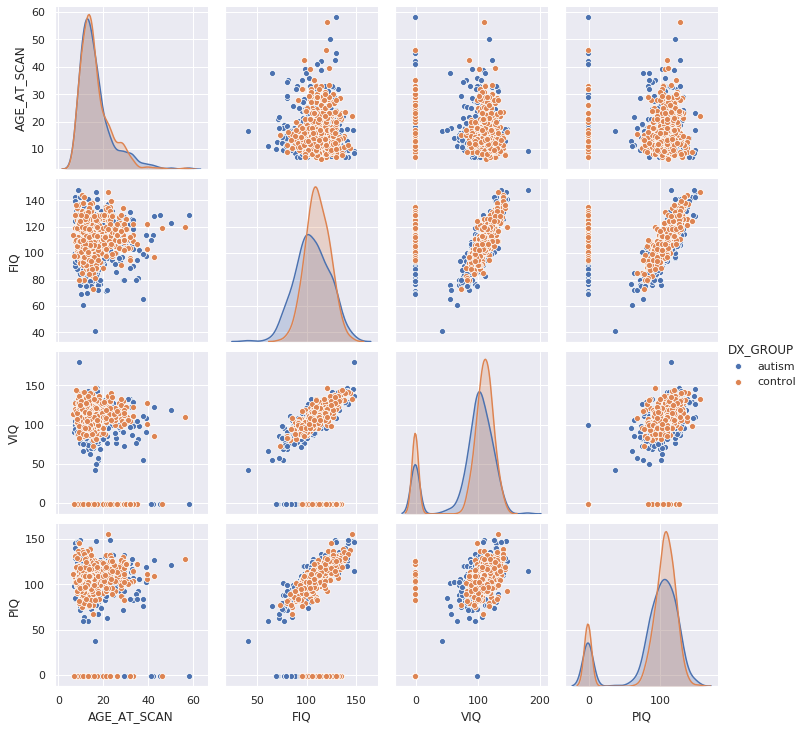

In [48]:
phen_miss=phen[["DX_GROUP", "SITE_ID", "DSM_IV_TR","AGE_AT_SCAN", "FIQ", "VIQ", "PIQ"]]

phen_miss=phen_miss.replace([-9999, "-9999"], ["NaN", "NaN"])
pd.set_option('display.max_rows', 500)

#for all val in phen_miss: 
#    if val=="NaN":
#        phen_miss.drop([0, 1])
        
phen_miss= phen_miss.drop(phen_miss[phen_miss.FIQ =="NaN"].index)
phen_miss= phen_miss.drop(phen_miss[phen_miss.VIQ =="NaN"].index)
phen_miss= phen_miss.drop(phen_miss[phen_miss.PIQ =="NaN"].index)

phen_miss.shape

#phen_miss_0= phen_miss[pd.notna(phen_miss['FIQ'])]

sns.set()
sns.pairplot(phen_miss, hue= "DX_GROUP")

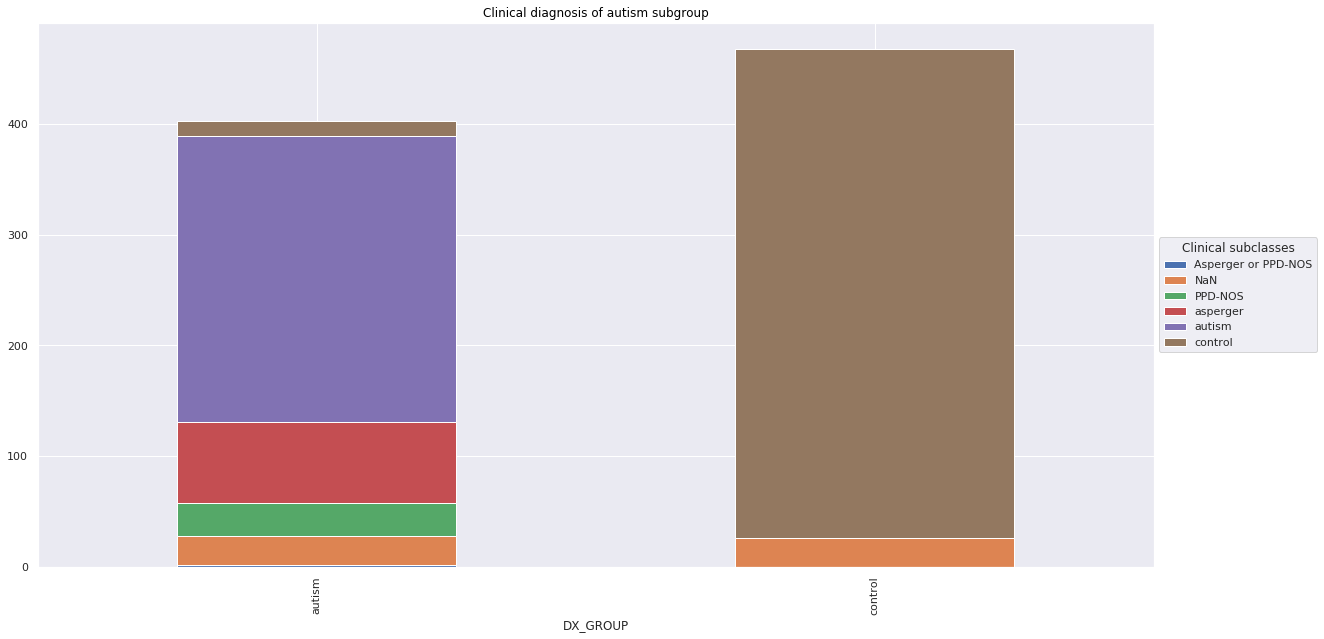

In [120]:
#clinical sub-classes of subjects classified as autistic
sns.set()

pd.crosstab(index=phen['DX_GROUP'],
                columns=phen['DSM_IV_TR']).plot.bar(stacked=True)

plt.title('Clinical diagnosis of autism subgroup', color='black')
plt.legend(title='Clinical subclasses', loc='center left', bbox_to_anchor=(1.0, 0.5))
plt.gcf().set_size_inches(20, 10)

/home/anproulx/miniconda3/lib/python3.7/site-packages/ipykernel_launcher.py:14: MatplotlibDeprecationWarning:

Non-1D inputs to pie() are currently squeeze()d, but this behavior is deprecated since 3.1 and will be removed in 3.3; pass a 1D array instead.



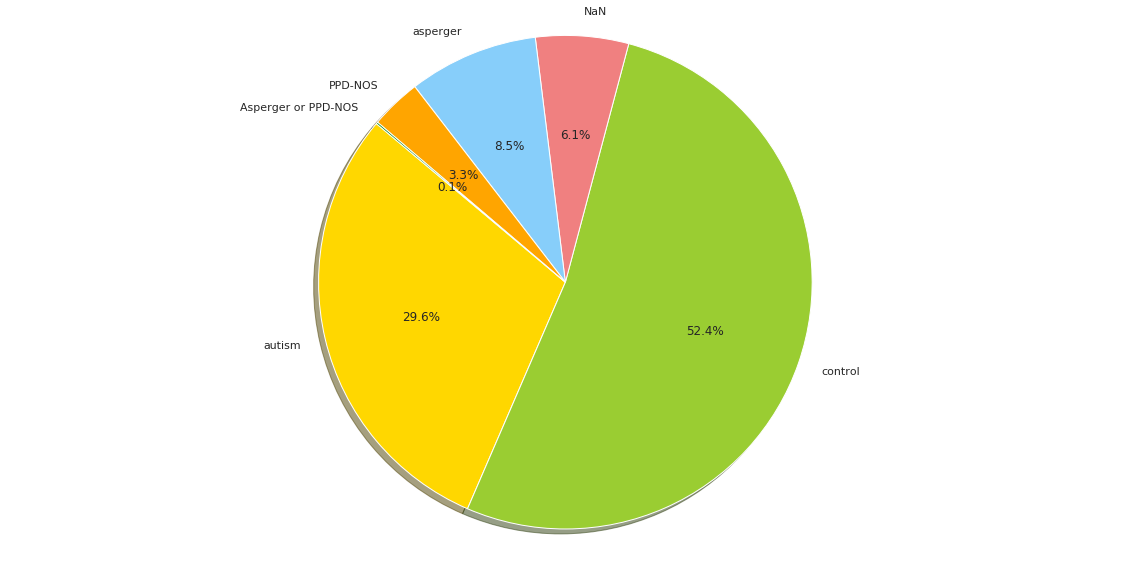

In [121]:
# Data to plot
sns.set()
labels = phen["DSM_IV_TR"].drop_duplicates()
#print(labels)

size=pd.DataFrame(phen["DSM_IV_TR"].groupby(phen["DSM_IV_TR"]).count())
resize= size.reindex(['autism', 'control', 'NaN', 'asperger', 'PPD-NOS', 'Asperger or PPD-NOS'])
#print(resize)

colors = ['gold', 'yellowgreen', 'lightcoral', 'lightskyblue', 'orange', 'green']

# Plot
plt.pie(resize, labels=labels, colors=colors,
autopct='%1.1f%%', shadow=True, startangle=140)

plt.axis('equal')
plt.gcf().set_size_inches(20, 10)

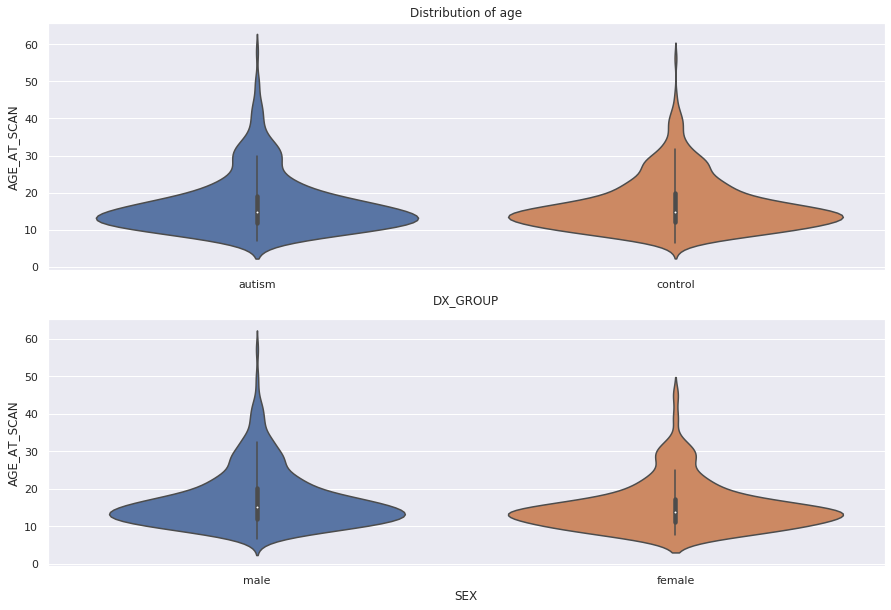

In [122]:
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(15 , 10))

ax1 = plt.subplot(2,1,1) 
plt.title("Distribution of age")

sns.violinplot(x='DX_GROUP', 
            y = 'AGE_AT_SCAN',
            data = phen)

ax1 = plt.subplot(2,1,2) 
sns.violinplot(x='SEX', 
            y = 'AGE_AT_SCAN',
            data = phen)

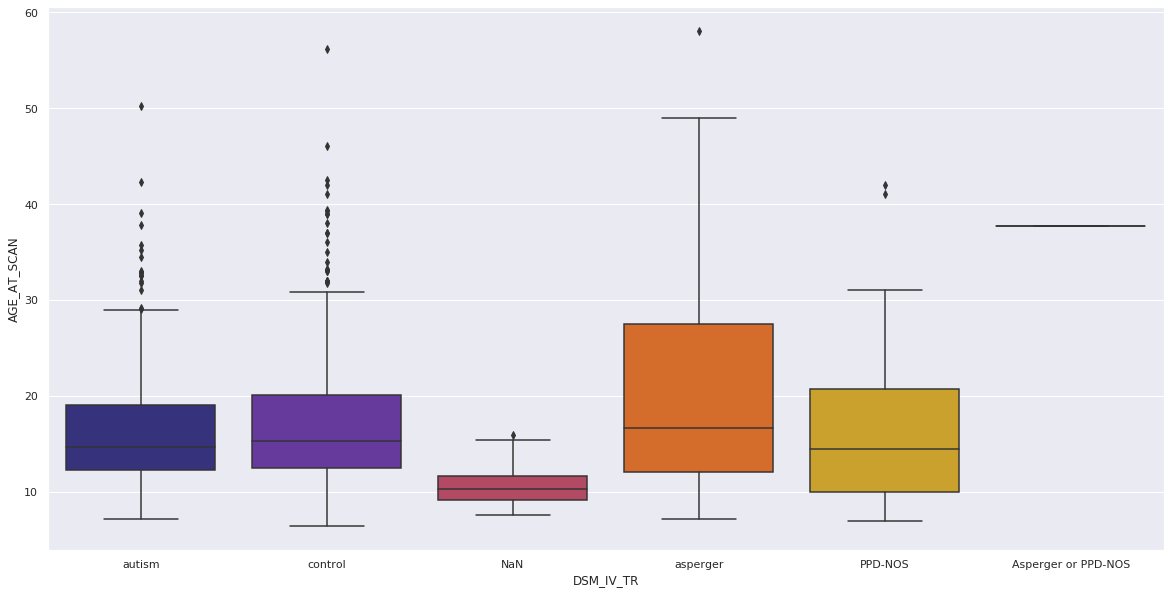

In [123]:
fig, ax = plt.subplots(figsize=(20 , 10))

sns.boxplot(x='DSM_IV_TR', 
            y = 'AGE_AT_SCAN',
            data = phen,
            palette = "CMRmap"
           )

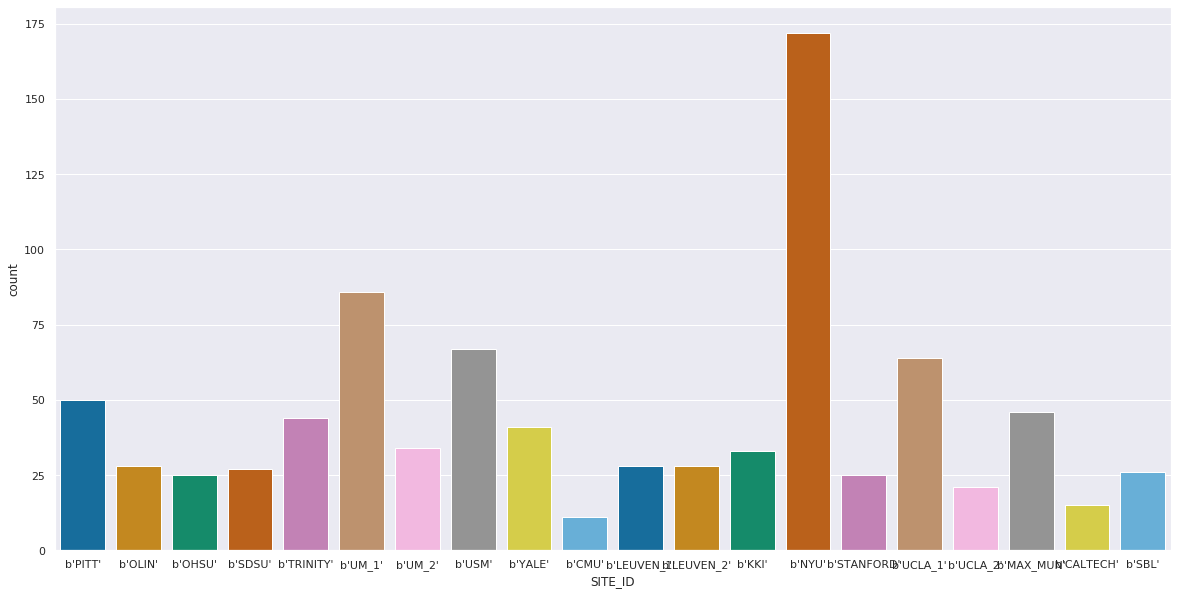

In [13]:
#Data on acquisition sites
fig, ax = plt.subplots(figsize=(20 , 10))
sns.countplot('SITE_ID', data=phen, palette="colorblind")

(array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
        17, 18, 19]),
 <a list of 20 Text xticklabel objects>)

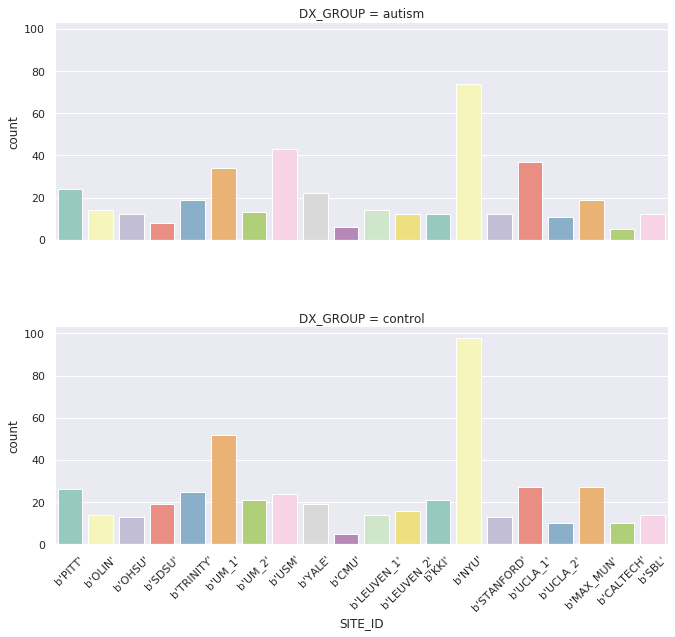

In [124]:
ax= sns.catplot(x="SITE_ID",
                data=phen, row="DX_GROUP", orient="h", height=2, aspect=3, palette="Set3",
                kind="count", dodge=True);

plt.gcf().set_size_inches(10, 10)
plt.xticks(rotation = 45)

# Data exploration with interactive plotting (Plotly)

In [49]:
#basic interactive plot
phen["SEX"].iplot(kind='hist', xTitle='Gender',
                  yTitle='Count', title='Count of f/m')

In [50]:
phen['DSM_IV_TR'].iplot(kind='hist', xTitle='Clinical condition',
                  yTitle='count', title='Clinical distribution', colors="blue")

In [51]:
phen.pivot(columns='DSM_IV_TR', values= "AGE_AT_SCAN").iplot(
        kind='box',
        yTitle='AGE_AT_SCAN',
        title='Age distribution in different clinical conditions')

In [180]:
from plotly.subplots import make_subplots

#fig = make_subplots(
#    rows=2, cols=1,
#    row_width=[0.33, 0.67],
#    start_cell="top-left")

#fig.add_bar(x=phen["DSM_IV_TR"], row=1, col=1)
#fig.add_bar(y=phen["DX_GROUP"], row=2, col=1)
#fig.show()

In [142]:
import plotly.express as px


fig = px.scatter(phen, x="AGE_AT_SCAN",  color="SITE_ID", title="Age distribution in different fmri acquisition site")

# If you print fig, you'll see that it's just a regular figure with data and layout
# print(fig)
fig.update_traces(
    line=dict(dash="dot", width=4),
    selector=dict(type="scatter", mode="lines"))

fig.show()

In [192]:
fig = px.scatter(phen, x="AGE_AT_SCAN", animation_frame="DSM_IV_TR", animation_group="SUB_ID", color="SITE_ID", hover_name="SUB_ID", facet_col="SEX",
           log_x=False, size_max=45, range_x=[1,100], range_y=[-5,100])
fig.show()

In [196]:
fig = px.box(phen, x="DSM_IV_TR", y="AGE_AT_SCAN", color="SEX", notched=True)
fig.show()

In [136]:
#fig = px.scatter(phen, x="AGE_AT_SCAN",  color="SITE_ID", facet_col="SITE_ID", title="Age distribution in different fmri acquisition site")
#fig.show()

In [28]:
#make value into dictionary
phen_grby= phen.groupby(phen["SITE_ID"])

DDEAL WITH MISSING DATA BEFORE GETTING INTO ML: EXCLUSION PARTICIPANT WITH MISSING DATA

In [60]:
#subset the features we are interested in

print(phen.shape)

phen_predict = phen[phen["DX_GROUP"]!="NaN"]
phen_predict.shape

#No missing data for DX_GROUP 

(871, 105)


(871, 105)

# Extracting the features (X) 

In [162]:
#fetch atlas for brain parcellation
parcellations = datasets.fetch_atlas_basc_multiscale_2015(version='sym')
atlas_filename = parcellations.scale064

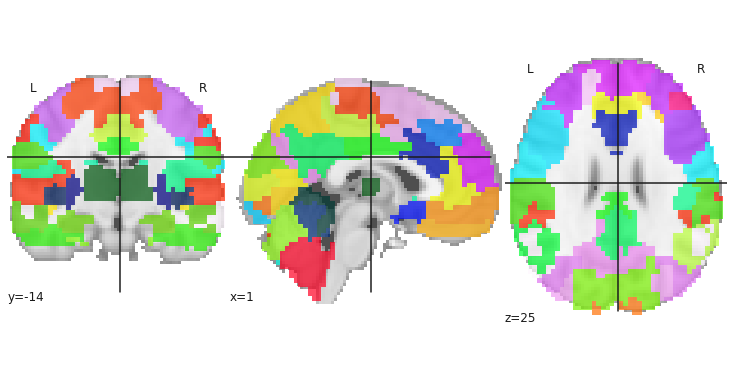

In [163]:
from nilearn import plotting

plotting.plot_roi(atlas_filename, draw_cross=True)
plt.gcf().set_size_inches(10, 5)

Preprocessing to create connectome for 1 subject, than will be implemented for all 800.. subjects

In [164]:
fmri_filenames = data.func_preproc[100] #100 subject in the folder
print(fmri_filenames)

/home/anproulx/nilearn_data/ABIDE_pcp/cpac/nofilt_noglobal/OHSU_0050169_func_preproc.nii.gz


In [166]:
from nilearn import image
from nilearn.image import load_img
im= load_img(fmri_filenames)

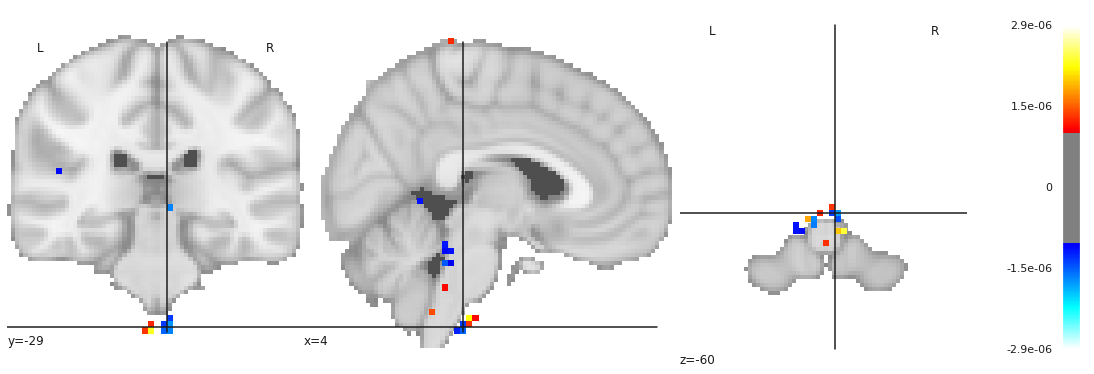

In [165]:
averaged_Img = image.mean_img(fmri_filenames)
plotting.plot_stat_map(averaged_Img)
plt.gcf().set_size_inches(15, 5)

In [167]:
#Extract features (what about the confounds, does the data contain any regressors?????)
from nilearn.input_data import NiftiLabelsMasker

masker = NiftiLabelsMasker(labels_img=atlas_filename, 
                           standardize=True, 
                           memory='nilearn_cache', 
                           verbose=1)

time_series = masker.fit_transform(fmri_filenames)

[NiftiLabelsMasker.fit_transform] loading data from /home/anproulx/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
Resampling labels


In [85]:
time_series.shape

(78, 64)

In [169]:
from nilearn.connectome import ConnectivityMeasure
correlation_measure = ConnectivityMeasure(kind='correlation')
correlation_matrix = correlation_measure.fit_transform([time_series])[0]
correlation_matrix.shape

(64, 64)

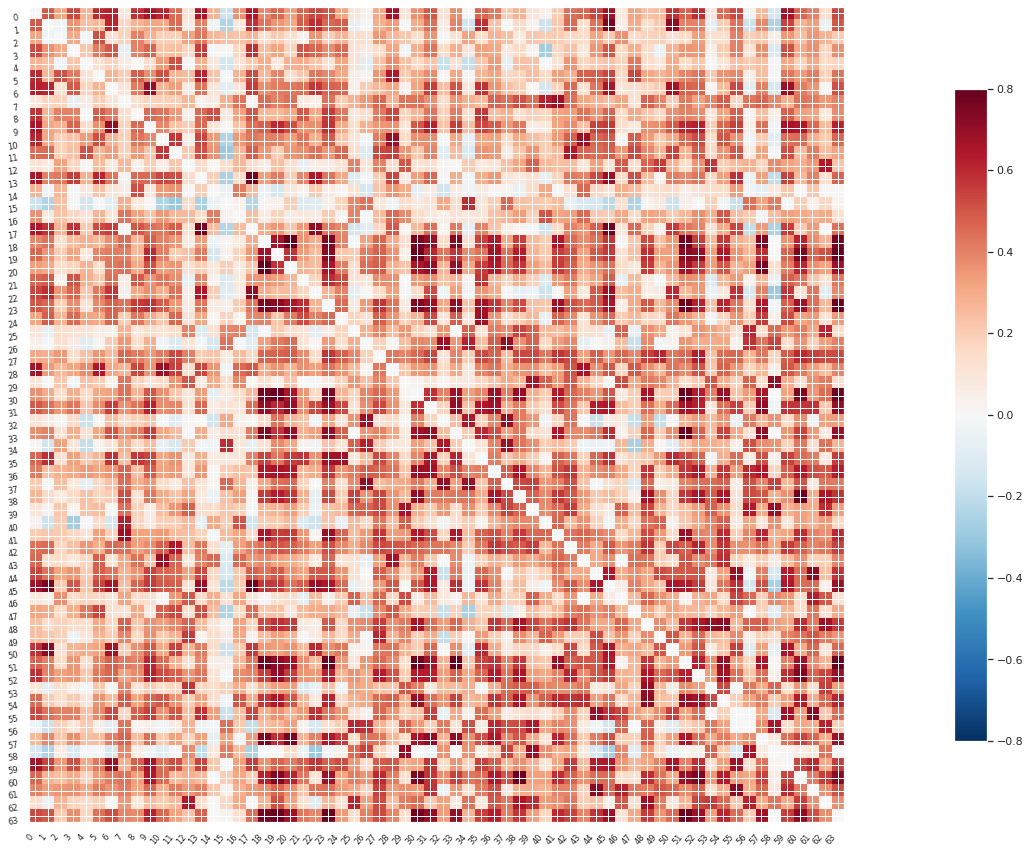

In [170]:
np.fill_diagonal(correlation_matrix, 0)
plotting.plot_matrix(correlation_matrix, figure=(25, 15),   
                     labels=range(time_series.shape[-1]),
                     vmax=0.8, vmin=-0.8, reorder=False) #reorder= True does clustering within the matrix

#remove grid

In [329]:
import plotly.figure_factory as ff

corr= pd.DataFrame(correlation_matrix)

corrs = corr.corr()
figure = ff.create_annotated_heatmap(
    z=corrs.values,
    x=list(corrs.columns),
    y=list(corrs.index),
    annotation_text=corrs.round(2).values,
    showscale=True)

figure.update_layout(
    autosize=False,
    width=2000,
    height=2000)

Extract features for ALL subjects: implement loop over funct_preproc files

In [92]:
all_features = []

for i,sub in enumerate(data.func_preproc):
    # extract the timeseries from the ROIs in the atlas
    time_series = masker.fit_transform(sub)
    
    # create a region x region correlation matrix
    correlation_matrix = correlation_measure.fit_transform([time_series])[0]
    
    # add to our container
    all_features.append(correlation_matrix)
    
    # keep track of status
    print('finished %s of %s'%(i+1,len(data.func_preproc)))

[NiftiLabelsMasker.fit_transform] loading data from /home/anproulx/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
finished 1 of 871
[NiftiLabelsMasker.fit_transform] loading data from /home/anproulx/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
finished 2 of 871
[NiftiLabelsMasker.fit_transform] loading data from /home/anproulx/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
finished 3 of 871
[NiftiLabelsMasker.fit_transform] loading data from /home/anproulx/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multiscale_nii_sym/template_cambridge_basc_multiscale_sym_scale064.nii.gz
finished 4 of 871
[NiftiLabelsMasker.fit_transform] loading data from /home/anproulx/nilearn_data/basc_multiscale_2015/template_cambridge_basc_multisc

In [199]:
#Reshape individual connectome to 1 dimension (flat array)
'''for i in range (len(all_features)):
    all_features[i]=np.triu(all_features[i]).flatten()
i=i+1'''

#save to lacal space
np.savez_compressed('MAIN_BASC064_subsamp_connectomes_half', a = all_features)

'for i in range (len(all_features)):\n    all_features[i]=np.triu(all_features[i]).flatten()\ni=i+1'

In [200]:
feat_file = 'MAIN_BASC064_subsamp_connectomes_half.npz'

X_features = np.load(feat_file)['a']

X_features.shape

#Since the matrix is symmetric, we only need to keep one half of the connectome!

(871, 4096)

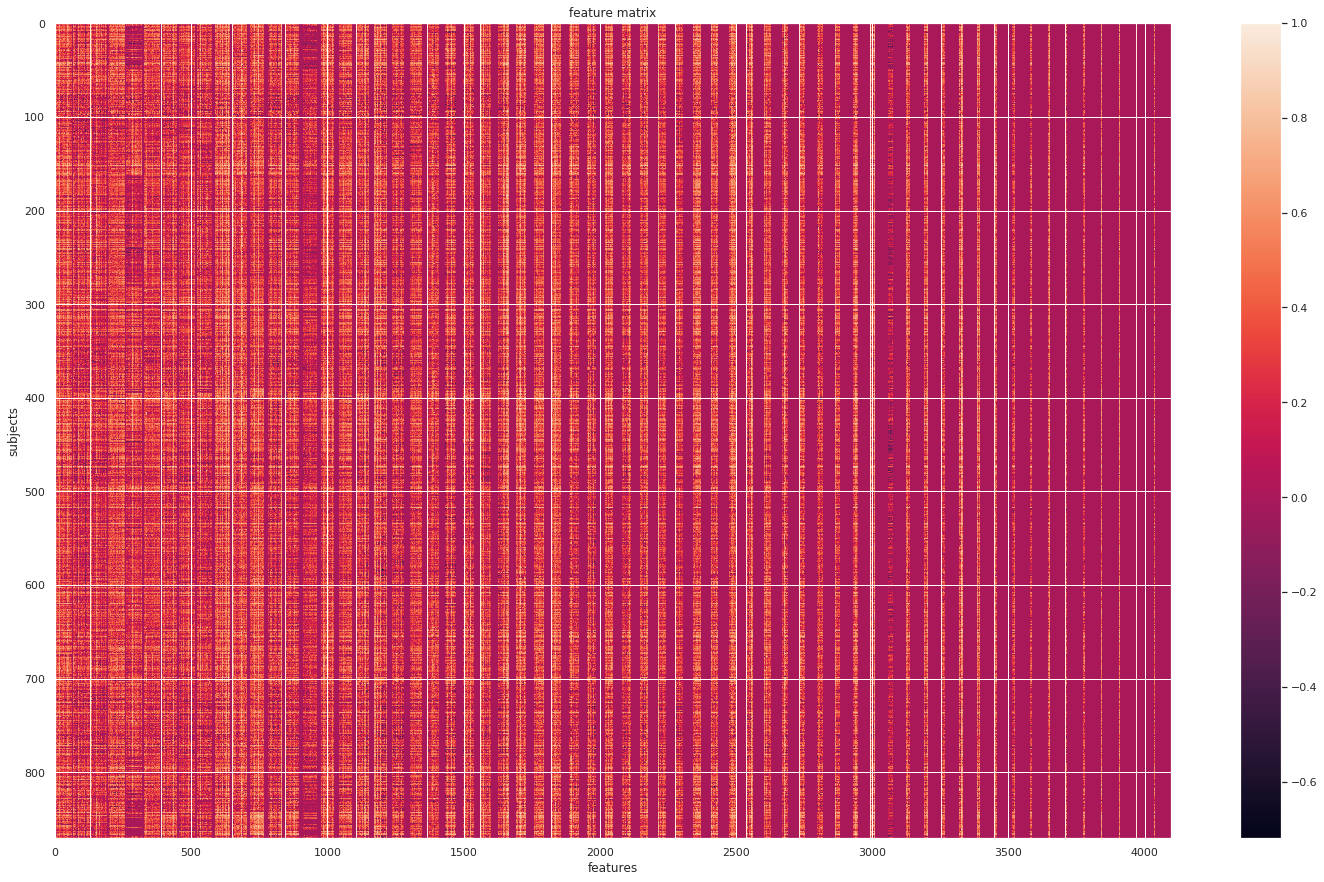

In [201]:
#plot feature matrix

import matplotlib.pyplot as plt

plt.imshow(X_features, aspect='auto')
plt.colorbar()
plt.title('feature matrix')
plt.xlabel('features')
plt.ylabel('subjects')

plt.gcf().set_size_inches(25, 15)

# Get the target vector (Y)

In [202]:
y=phen['DX_GROUP']

In [203]:
#basic interactive plot
phen["DX_GROUP"].iplot(kind='hist', xTitle='Status',
                  yTitle='Count', title='Count of controls/autism subjects')

# Predicting labels: probabilistic and non-probabilistic classification models

1. Choose a class of model
2. Choose model hyperparameters
3. Fit the model to the training data
4. Use the model to predict labels for new data

# Dimensionality reduction with PCA

PCA is fundamentally a
dimensionality reduction algorithm, but it can also be useful as a tool for visualization,
for noise filtering, for feature extraction and engineering, and much more. Using PCA for dimensionality reduction involves zeroing out one or more of the
smallest principal components, resulting in a lower-dimensional projection of the
data that preserves the maximal data variance.

In [220]:
sns.set()
from sklearn.decomposition import PCA

pca = PCA().fit(X_features)
#Around 800 components explains close 1,0 of the variance. Important reduction of features (4096 features initially) !!!

In [219]:
#make df with components and cumulative explained variance ratio
df_plotly=pd.DataFrame()
df_plotly["cumulative_variance_ratio_explained"]=np.cumsum(pca.explained_variance_ratio_)

fig = px.line(df_plotly, y="cumulative_variance_ratio_explained",
        line_shape="spline", render_mode="svg", title="Cumulative variance ratio explained represented as a function of n components")
fig.show()

In [221]:
from sklearn.decomposition import PCA
pca = PCA(600) #choose n components for 99% variance explained
pca.fit(X_features)
X_features_pca = pca.transform(X_features)


print("original shape: ", X_features.shape)
print("transformed shape:", X_features_pca.shape)

#print(pca.components_)

original shape:  (871, 4096)
transformed shape: (871, 600)


In [222]:
#ls_components = pca.components_
#shape_components = ls_components.shape
#nr_components = shape_components[0]

explained_variance = pca.explained_variance_ratio_

#print(ls_components)

In [223]:
dic_comps = {'PC{}'.format(i): explained_variance[i] for i in range(len(explained_variance))}
df_comps = pd.DataFrame(dic_comps.values(), index = dic_comps.keys(), columns=['explained_variance'])

df_comps.head()

explained_variance
PC0            0.349732
PC1            0.045420
PC2            0.027524
PC3            0.026403
PC4            0.021305

X is now X_features_pca

In [224]:
from sklearn.model_selection import train_test_split
Xtrain, Xtest, ytrain, ytest = train_test_split(X_features_pca, y, test_size=0.20, shuffle = True, # shuffle dataset
stratify = y)

In [225]:
#Makig sure that the distribution of control/autism stay similar for train-test set
ytest.iplot(kind='hist', xTitle='Status',
                  yTitle='Count', title='Count of controls/autism subjects for test data', colors="blue")

ytrain.iplot(kind='hist', xTitle='Status',
                  yTitle='Count', title='Count of controls/autism subjects for training data', colors="blue")

SearchGrid & validation curves for choosing best hyperparameters. ***To distinguish from learning curves which tells us how we benefit from adding observations to our training data. 

# Support Vector Machines (SVM)

 Finds a line or curve (in two dimensions) or manifold (in multiple dimensions)
that divides the classes from each other. In support vector machines, the line that maximizes this margin is the one we will
choose as the optimal model. Support vector machines are an example of such a maximum
margin estimator.  Because they are affected only by points near the margin, they work well with
high-dimensional data—even data with more dimensions than samples, which is
a challenging regime for other algorithms.

C parameter: The hardness of the margin is controlled by a tuning parameter, most
often known as C. For very large C, the margin is hard, and points cannot lie in it. For
smaller C, the margin is softer, and can grow to encompass some points.

*Source Python Data Science Handbook

# ***Selecting best value for GAMMA hyperparameter

In [230]:
#Depicting validation curve for different gamma values

param_range = np.logspace(-6, 3 , 20)

train_scores, test_scores = validation_curve(
    SVC(), X_features_pca, y, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print(test_scores_std)
print(param_range)

[0.00257161 0.00257161 0.00257161 0.00257161 0.00257161 0.00257161
 0.00257161 0.03026893 0.02592606 0.01849552 0.01992828 0.00257161
 0.00257161 0.00257161 0.00257161 0.00257161 0.00257161 0.00257161
 0.00257161 0.00257161]
[1.00000000e-06 2.97635144e-06 8.85866790e-06 2.63665090e-05
 7.84759970e-05 2.33572147e-04 6.95192796e-04 2.06913808e-03
 6.15848211e-03 1.83298071e-02 5.45559478e-02 1.62377674e-01
 4.83293024e-01 1.43844989e+00 4.28133240e+00 1.27427499e+01
 3.79269019e+01 1.12883789e+02 3.35981829e+02 1.00000000e+03]


In [312]:
df_gamma= pd.DataFrame()

train_score_flat=train_scores[5:12,3]
train_score_flat

test_scores_flat=test_scores[5:12 , 3]

df_gamma["gamma"]=param_range[5:12]
df_gamma["train_scores"]=train_score_flat
df_gamma["test_scores"]=test_scores_flat

df_gamma

gamma  train_scores  test_scores
0  0.000234      0.536585     0.540230
1  0.000695      0.536585     0.540230
2  0.002069      0.658537     0.614943
3  0.006158      0.802009     0.649425
4  0.018330      0.958393     0.637931
5  0.054556      1.000000     0.557471
6  0.162378      1.000000     0.540230

In [313]:
fig = px.line(df_gamma, x="gamma", y="train_scores", hover_name="gamma", animation_group="gamma",
        line_shape="spline", render_mode="svg")

fig = px.line(df_gamma, x="gamma", y="test_scores", hover_name="test_scores", animation_group="gamma",
        line_shape="spline", render_mode="svg")
fig.show()

#can i make it interactive even more....%??

In [331]:
import plotly.graph_objects as go


title = 'Validation curve'
labels = ['train_scores', 'test_scores']
colors = ['rgb(67,67,67)', 'rgb(115,115,115)']
line_size = [2, 2]

fig = go.Figure()

for i in range(0, 2):
    fig.add_trace(go.Scatter(x=df_gamma["gamma"], y=df_gamma[labels[i]], mode='lines',
        name=labels[i],
        line=dict(color=colors[i], width=line_size[i]),
        connectgaps=True,
    ))
    
    #fig.add_trace(go.Scatter(
    #    x=[df_gamma["gamma"][0], df_gamma["gamma"][-1]],
    #    y=[df_gamma[labels[i]][0], df_gamma[labels[i]][-1]],
    #    mode='markers',
    #    marker=dict(color=colors[i], size=mode_size[i])
    #))

annotations = []
   
annotations.append(dict(xref='paper', yref='paper', x=0.0, y=1.05,
                              xanchor='left', yanchor='bottom',
                              text='Validation curve for different gamma values',
                              font=dict(family='Arial',
                                        size=30,
                                        color='rgb(37,37,37)'),
                              showarrow=False))

#for y_trace, label, color in zip(y_data, labels, colors):
    # labeling the left_side of the plot
#    annotations.append(dict(xref='paper', x=0.05, y=y_trace[0],
#                                  xanchor='right', yanchor='middle',
#                                  text=label + ' {}%'.format(y_trace[0]),
#                                  font=dict(family='Arial',
                                           # size=16),

fig.update_layout(annotations=annotations)

fig.show()

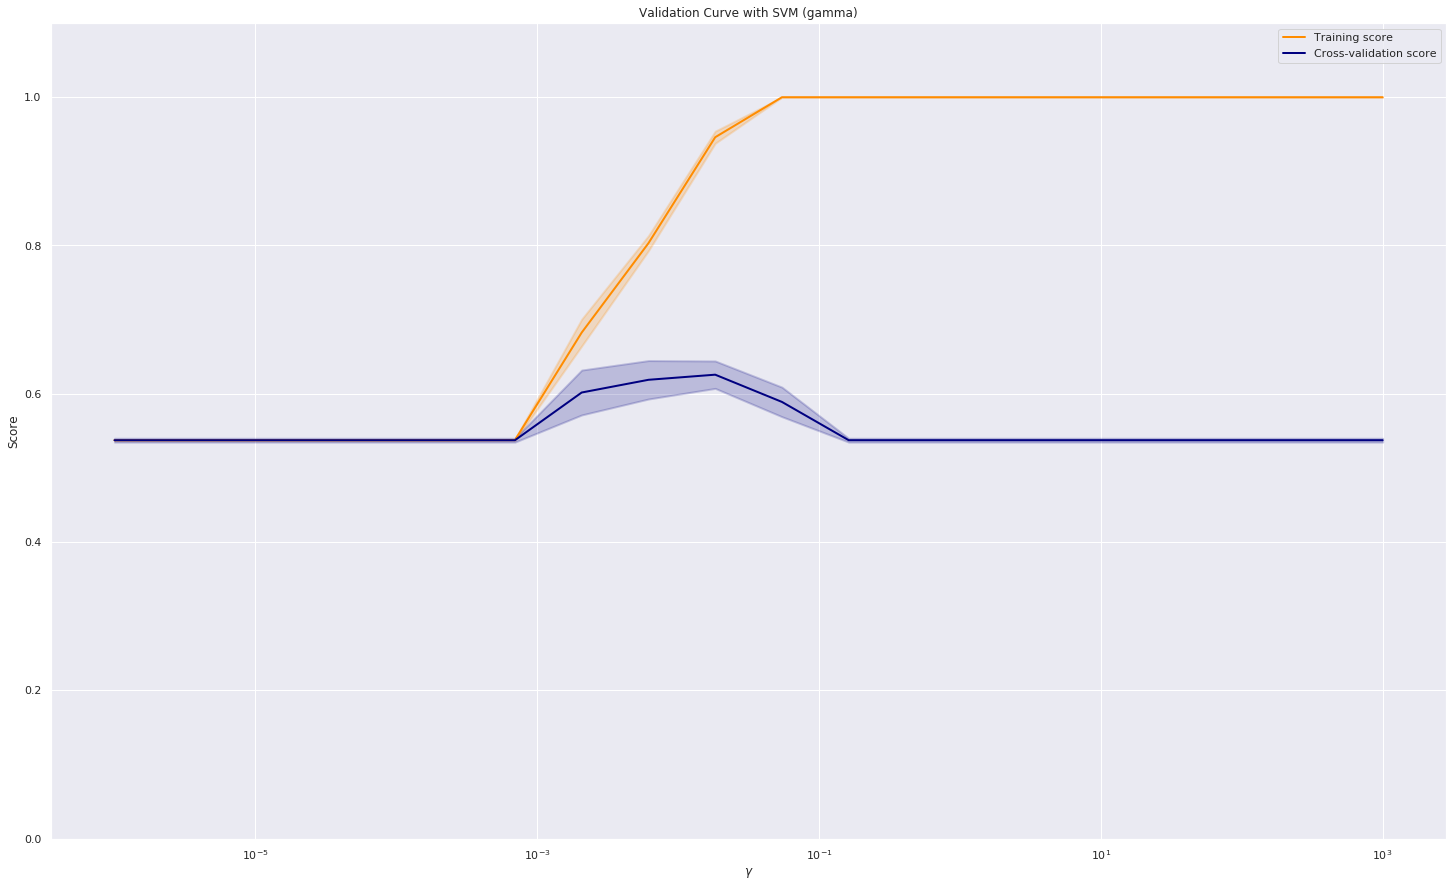

In [227]:
# Plot learning curve

plt.title("Validation Curve with SVM (gamma)")
plt.xlabel(r"$\gamma$")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.gcf().set_size_inches(25, 15)


***Selecting C hyperparameter

In [40]:
#let's plot a validation curve, this time for the "c" hyperparameter

param_range = np.logspace(-4, 3 , 10)

train_scores, test_scores = validation_curve(
    SVC(), X_features_pca, y, param_name="C", param_range=param_range,
    scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print(test_scores_std)

[0.00257161 0.00257161 0.00257161 0.00257161 0.00257161 0.01020211
 0.03657702 0.03742569 0.03742569 0.03742569]


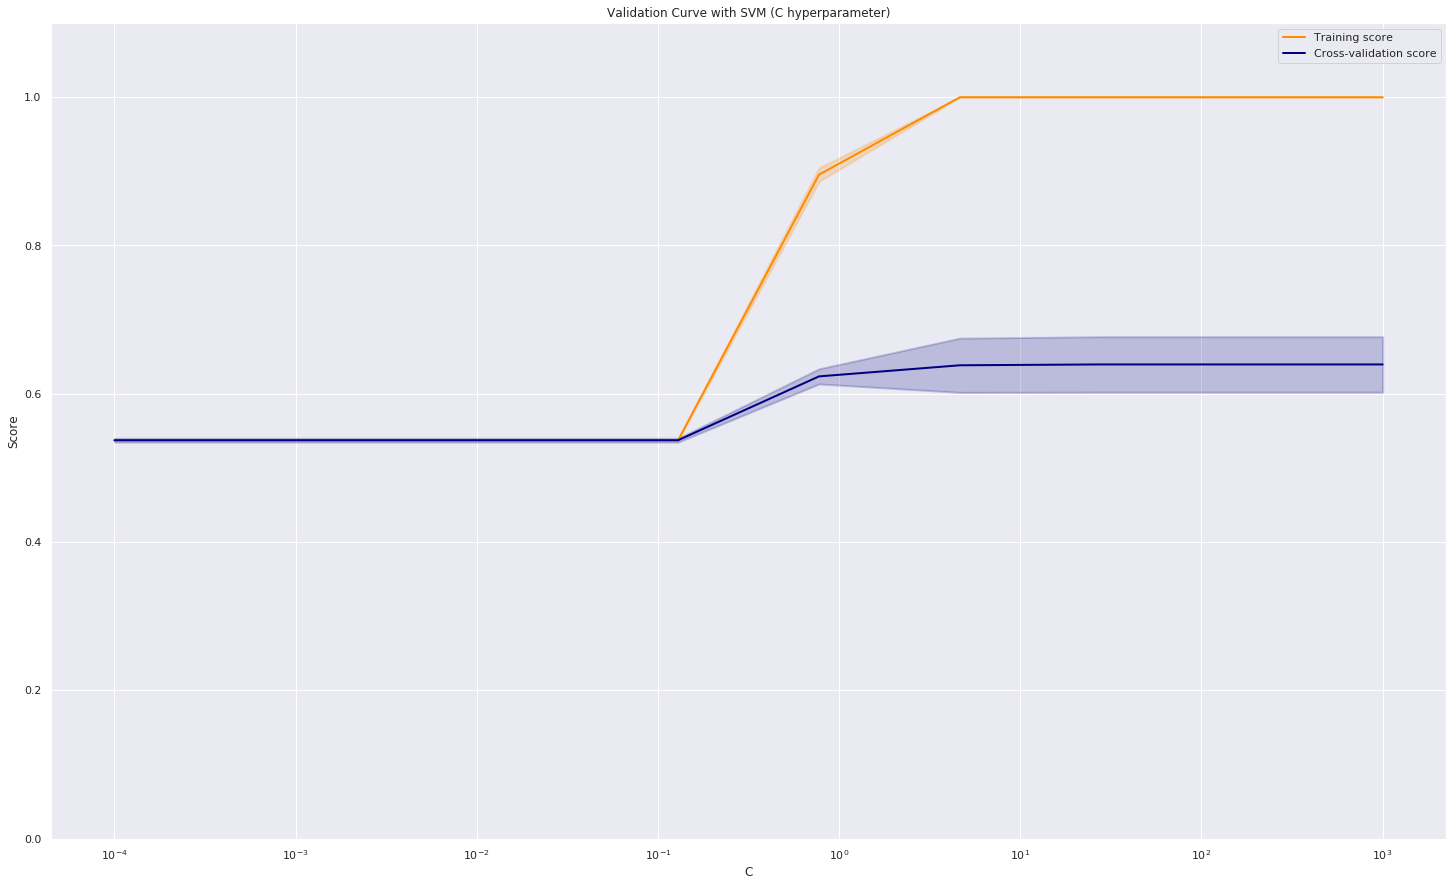

In [116]:
plt.title("Validation Curve with SVM (C hyperparameter)")
plt.xlabel("C")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.gcf().set_size_inches(25, 15)

In [28]:
#Using gridsearch to find best parameters

from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC # "Support vector classifier"

model = SVC(kernel='linear')

model.get_params().keys()

param_grid = {'C': [0.1, 1,  5, 10, 50, 100],
              'gamma': [0.00001, 0.00005,  0.0001, 0.0005, 0.001, 0.005, 0.01]}
            
grid = GridSearchCV (model, param_grid, cv=7)
grid.fit(X_features_pca, y)

print(grid.best_params_)
model_best = grid.best_estimator_

{'C': 0.1, 'gamma': 0.0001}


In [72]:
#best parameters with training data from train-test split

grid_test_train = GridSearchCV (model, param_grid, cv=7)
grid_test_train.fit(Xtrain , ytrain)

print (grid_test_train.best_params_)

model_best_train_test = grid_test_train.best_estimator_

#should I increase the lower range?

{'C': 0.1, 'gamma': 0.0001}


Predict & validate de model. For this next part, the classification will be validated using 3 methods
1. test-train
2. k-fold cross validation
3. leave-one out 

Accuracy score using best parameters is : 0.6514285714285715


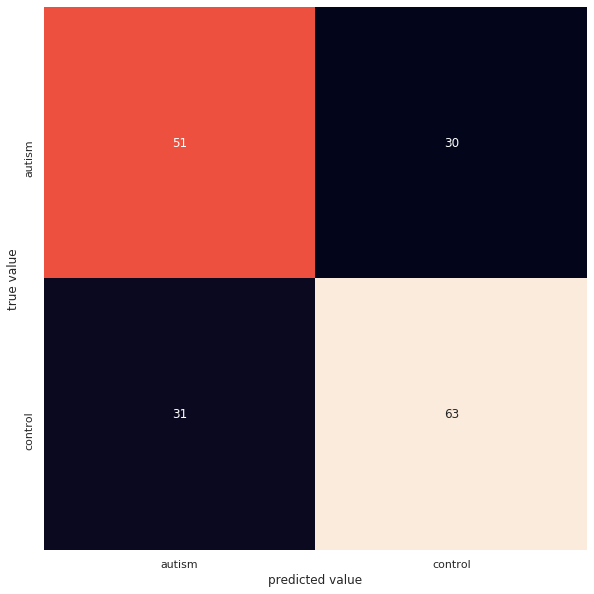

In [79]:
#TRAIN-TEST VALIDATION

y_pred=model_best_train_test.predict(Xtest)

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, y_pred)
sns.heatmap(mat, square=True, annot=True, cbar=False, xticklabels= ["autism", "control"], yticklabels=["autism", "control"])
plt.xlabel('predicted value')
plt.ylabel('true value')


from sklearn.metrics import accuracy_score
print("Accuracy score using best parameters is :", accuracy_score (ytest, y_pred))

plt.gcf().set_size_inches(10, 10)

In [71]:
#cross-validation K-FOLDS

from sklearn.model_selection import cross_val_score
cross_val_score(model_best, X_features_pca, y, cv=10).mean() #cv is the number of folds

0.6738897596656217

In [56]:
#Cross validation leave one out

from sklearn.model_selection import LeaveOneOut
scores = cross_val_score(model_best, X_features_pca, y, cv=LeaveOneOut())
scores.mean()

0.6831228473019518

# KNN

The KNN algorithm is a robust and versatile classifier that is often used as a reference for more complex classifiers such as Artificial Neural Networks (ANNs) and Support Vector Machines (SVMs).

KNN is supervised learning and works with labeled data sets including learning observations (x, y) and is used to capture the relationship between x and y (x = entity, predictor, attribute; y = target, label, class).

The KNN algorithm forms a majority vote between the K instances most similar to a given "invisible" observation.
The similarity is defined according to a distance metric between two data points (common choices: Euclidean distance, Manhattan, Chebyshev, Hamming).

In [112]:
from sklearn.neighbors import KNeighborsClassifier as KNN
from sklearn.preprocessing import LabelEncoder

param_range = np.arange (1, 100, 1)
print(param_range)

le = LabelEncoder()
label_encoder_y=le.fit_transform(y)

[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21 22 23 24
 25 26 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48
 49 50 51 52 53 54 55 56 57 58 59 60 61 62 63 64 65 66 67 68 69 70 71 72
 73 74 75 76 77 78 79 80 81 82 83 84 85 86 87 88 89 90 91 92 93 94 95 96
 97 98 99]


N_neighbor hyperparameter

In [113]:
train_scores, test_scores = validation_curve(
    KNN(), X_features_pca, label_encoder_y, param_name="n_neighbors", param_range=param_range,
    scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print(test_scores_std)

[0.05198424 0.03366477 0.04353848 0.0452103  0.02770854 0.03312484
 0.02533503 0.03467307 0.03822843 0.04870766 0.04556325 0.0258784
 0.03559052 0.03959323 0.03414228 0.02357567 0.038361   0.0308751
 0.0303658  0.02287947 0.03311075 0.02240281 0.03354986 0.02367309
 0.03274065 0.02996463 0.04125724 0.02926877 0.03001683 0.0281865
 0.02387212 0.02783619 0.0318261  0.03859116 0.0298126  0.03958922
 0.02958187 0.02433638 0.02296547 0.02797736 0.02424771 0.02719525
 0.02071733 0.025805   0.03100126 0.03410398 0.02873259 0.02495709
 0.01390812 0.01701766 0.01701974 0.023176   0.02308199 0.01069345
 0.01875981 0.01969113 0.0253691  0.02065834 0.02192582 0.01314344
 0.01587146 0.01842147 0.01370685 0.02655745 0.02003673 0.02692458
 0.01791149 0.02302985 0.0243478  0.02699218 0.02165805 0.03325608
 0.03125224 0.03752699 0.02958695 0.03559515 0.03866656 0.03532626
 0.02901559 0.02926521 0.02621764 0.02916883 0.02839371 0.02213723
 0.02374591 0.02525026 0.02515817 0.02756524 0.02667794 0.0211159

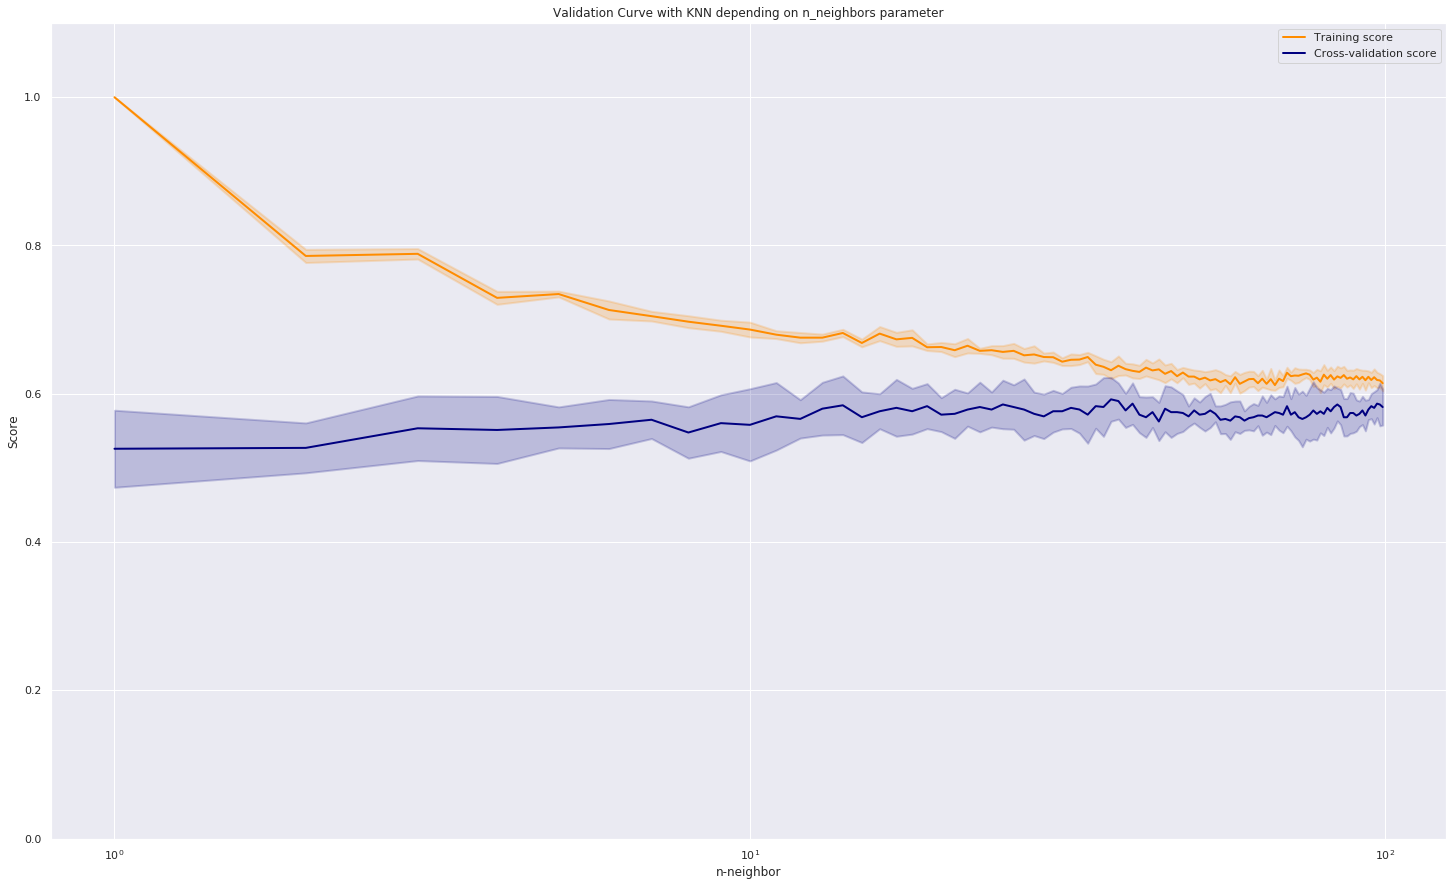

In [114]:
# Plot learning curve

plt.title("Validation Curve with KNN depending on n_neighbors parameter")
plt.xlabel("n-neighbor")
plt.ylabel("Score")
plt.ylim(0.0, 1.1)
lw = 2

plt.semilogx(param_range, train_scores_mean, label="Training score",
             color="darkorange", lw=lw)
plt.fill_between(param_range, train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, alpha=0.2,
                 color="darkorange", lw=lw)
plt.semilogx(param_range, test_scores_mean, label="Cross-validation score",
             color="navy", lw=lw)
plt.fill_between(param_range, test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std, alpha=0.2,
                 color="navy", lw=lw)
plt.legend(loc="best")
plt.gcf().set_size_inches(25, 15)

# Metric (distance) hyperparameter 

# Gaussian Naives Bayes

Information on the estimator: Proceeds by assuming each class is drawn from an axis-aligned Gaussian distribution. Because it is so fast and has no hyperparameters to choose, Gaussian Naive Bayes is often a good model to use as a baseline classification, before you explore whether improvements can be found through more sophisticated models.

*Source: Python Data Science Handbook

In [ ]:
from sklearn.naive_bayes import GaussianNB

param_range = np.logspace(-6, 3 , 20)

train_scores, test_scores = validation_curve(
    SVC(), X_features_pca, y, param_name="gamma", param_range=param_range,
    scoring="accuracy", n_jobs=1)

train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
test_scores_mean = np.mean(test_scores, axis=1)
test_scores_std = np.std(test_scores, axis=1)

print(test_scores_std)

In [ ]:

#fit model to the data
model_GNB = GaussianNB()
model_GNB.fit(Xtrain, ytrain)
y_model = model.predict(Xtest)

yprob = model.predict_proba(Xnew) #gives the probabilistic prediction
yprob[-8:].round(2)

#Possible to do a multidimensional visualization???.... 2016 feat....prob not. 

# Decision Tree and Random forests

Random forests are an example of an ensemble learner built on decision trees. A simple decision tree built on this data will iteratively split the data along one or the other axis according to some quantitative criterion, and at each level assign the label of the new region according to a majority vote of points within it. 

Deepness of the tree: Going to deep in the levels of the tree can lead to overfitting the data. 

The key observation is that the inconsistencies
tend to happen where the classification is less certain, and thus by using
information from both of multiple trees, we might come up with a better result. That's where bagging methods, in this case Random Forests, comes into place. 

*Source: Python Data Science Handbook

In [ ]:
from sklearn.tree import DecisionTreeClassifier
tree = DecisionTreeClassifier().fit(X, y)

In [ ]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier

tree = DecisionTreeClassifier()
bag = BaggingClassifier(tree, n_estimators=100, max_samples=0.8,
random_state=1)
bag.fit(X, y)

ypred = bag.predict(X)

# see t-SNE

# KDE-based Bayesian classifier

# Comparing performance: Validation 

In [ ]:
#WAYS TO VALIDATE THE DATA

#split train-test set
Xtrain, Xtest, ytrain, ytest = train_test_split(X, y, random_state=0)
from sklearn.metrics import accuracy_score
accuracy_score(ytest, y_model)

from sklearn.metrics import confusion_matrix
mat = confusion_matrix(ytest, y_model)
sns.heatmap(mat, square=True, annot=True, cbar=False)
plt.xlabel('predicted value')
plt.ylabel('true value');

#MORE ACCURATE is cross validation : avoid overfitting for more complex/flexible models

#cross-validation choosing the nb of folds
from sklearn.cross_validation import cross_val_score
cross_val_score(model, X, y, cv=5) #cv is the number of folds


#cross-validation leave-one out -> see Abraham reference....
from sklearn.cross_validation import LeaveOneOut
scores = cross_val_score(model, X, y, cv=LeaveOneOut(len(X)))
scores

#In peer clinic: we talked about cross validating leaving one site out

How to increases the accuracy of estimators

Of core importance is the following question: if our estimator is underperforming, how
should we move forward? There are several possible answers:

• Use a more complicated/more flexible model
• Use a less complicated/less flexible model
• Gather more training samples
• Gather more data to add features to each sample

*Source Python Data Science Handbook

In [ ]:
#General questions: 
#1. No confounds for the ABIDE dataset? ... how will it affect the prediction. 
#2. Is it normal that I get mostly no activation for mean image. (and looks like it is in weird places). 
#3. Why don't I get negative correlation in the matrix....
#4. what would be the advantage of using fisher transform VS the pearson corr. 
#5. Time series shape are not all the same. (78, 64) (128, 64)
#6. nilearn.decoding.SearchLight... interesting to use????
#7. to be able to compare the performance, do we need to have same training-test set?? or if we all do cross-val, it will be ok?

#5. compare matrixes between teammates: the degree of overlapping. 
#6. make sure the images have been preprocessed in a standardise way, otherwise won't be possible to compare models. 

In [ ]:
#how number of subjects affect performances
#visualize matrixes in the form of a connectogram

#At the moment, half the matrix=0. to I have to completly remove half the matrix before doing PCA. 
#see how to deal with confounds....
#for the hmw : interactive plots: https://medium.com/plotly/introducing-plotly-express-808df010143d

#how should I visualize multidimensional data and their classifiers: should I make ndim plot or does it not make sense
from mpl_toolkits import mplot3d
ax = plt.axes(projection='3d')
ax.scatter3D(XS[:, 0], XS[:, 1], XS[:, 2],
             **colorize)

# Unsupervised machine learning  

Defining subclasses within the autism group: unsupervised estimators can highlight interesting aspects of the data
without reference to any known labels. 

# K-MEANS clustering, GMM...

In [ ]:
# Extract most important features
most_important = [np.abs(ls_composantes[i]).argmax() for i in range(nr_composantes)]
most_important_names = [y[most_important[i]] for i in range(nr_composantes)]
dic_feat = {'PC{}'.format(i): most_important_names[i] for i in range(nr_composantes)}
df_feat = pd.DataFrame(dic_feat.values(), index = dic_feat.keys(), columns=['features'])

print(df_feat)

df_feat_comp = df_comps.join(df_feat, how="outer")
print(df_feat_comp)